# Installing Dependencies

In [1]:
!pip install -q transformers datasets accelerate

# Loading GSM8K Subset

In [2]:
from datasets import load_dataset

# Load a subset for faster experiments
gsm8k = load_dataset("gsm8k", "main", split="test[:50]")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [3]:
for i in range(3):
    print(f"Example {i+1}")
    print("Question:", gsm8k[i]["question"])
    print("Answer:", gsm8k[i]["answer"])
    print("-" * 50)

Example 1
Question: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
Answer: Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.
She makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.
#### 18
--------------------------------------------------
Example 2
Question: A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it take?
Answer: It takes 2/2=<<2/2=1>>1 bolt of white fiber
So the total amount of fabric is 2+1=<<2+1=3>>3 bolts of fabric
#### 3
--------------------------------------------------
Example 3
Question: Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repairs.  This increased the value of the house by 150%.  How much profit did he make?
Answer: 

# Defining few shot prompts

In [4]:
# ✍️ Few-shot Chain of Thought prompt examples
few_shot_prefix = """Q: Emily has 3 apples. Her friend gives her 2 more. How many apples does Emily have now?
A: Emily starts with 3 apples. Her friend gives her 2 more. So, 3 + 2 = 5. The answer is 5.

Q: A pen costs 2 dollars. John buys 4 pens. How much does he pay?
A: Each pen costs 2 dollars. John buys 4 pens. So, 2 × 4 = 8. The answer is 8.

Q: Jake read 5 pages on Monday and 7 pages on Tuesday. How many pages did he read in total?
A: Jake read 5 pages on Monday and 7 on Tuesday. So, 5 + 7 = 12. The answer is 12.
"""


# Function to evaluate methods

In [7]:
def evaluate_model_fewshot(model_id):
    print(f"Evaluating {model_id} with few-shot CoT...")
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=128
    )

    correct = 0
    total = 0

    for sample in gsm8k:
        question = sample["question"]
        gt_answer = sample["answer"].split("####")[-1].strip()

        prompt = few_shot_prefix + f"Q: {question}\nA:"
        output = pipe(prompt)[0]["generated_text"]

        numbers = re.findall(r"\d+(?:\.\d+)?", output.replace(",", ""))
        if numbers:
            pred = numbers[-1]
            if float(pred) == float(gt_answer):
                correct += 1

        total += 1

    acc = correct / total
    print(f"Accuracy: {acc:.2%}")
    return acc

# Comparing accuracies for different model sizes

Evaluating google/flan-t5-small with few-shot CoT...


Loading weights:   0%|          | 0/190 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
Passing `generation_config` together with generation-related arguments=({'max_new_tokens'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.
The model 'T5ForConditionalGeneration' is not supported for text-generation. Supported models are ['PeftModelForCausalLM', 'AfmoeForCausalLM', 'ApertusForCausalLM', 'ArceeForCausalLM', 'AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BitNetForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'BltForCausalLM', 'CamembertForCausalLM

Accuracy: 4.00%
Evaluating google/flan-t5-base with few-shot CoT...


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/282 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

The model 'T5ForConditionalGeneration' is not supported for text-generation. Supported models are ['PeftModelForCausalLM', 'AfmoeForCausalLM', 'ApertusForCausalLM', 'ArceeForCausalLM', 'AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BitNetForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'BltForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'CwmForCausalLM', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV2ForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'DogeForCausalLM', 'Dots1ForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'Ernie4_5ForCausalLM', 'Ernie4_5_MoeForCausalLM', 'Exaone4ForCausalLM', 'FalconForCausalLM', 'FalconH1ForCausalLM', 'FalconMambaForCausa

Accuracy: 4.00%
Evaluating google/flan-t5-large with few-shot CoT...


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/558 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

The model 'T5ForConditionalGeneration' is not supported for text-generation. Supported models are ['PeftModelForCausalLM', 'AfmoeForCausalLM', 'ApertusForCausalLM', 'ArceeForCausalLM', 'AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BitNetForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'BltForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'CwmForCausalLM', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV2ForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'DogeForCausalLM', 'Dots1ForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'Ernie4_5ForCausalLM', 'Ernie4_5_MoeForCausalLM', 'Exaone4ForCausalLM', 'FalconForCausalLM', 'FalconH1ForCausalLM', 'FalconMambaForCausa

Accuracy: 4.00%


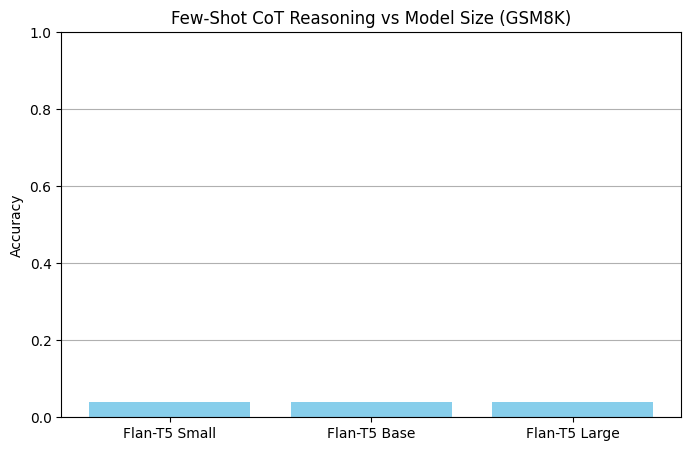

In [8]:
import matplotlib.pyplot as plt

model_ids = {
    "Flan-T5 Small": "google/flan-t5-small",
    "Flan-T5 Base": "google/flan-t5-base",
    "Flan-T5 Large": "google/flan-t5-large"
}

results = []
for label, model in model_ids.items():
    acc = evaluate_model_fewshot(model)
    results.append((label, acc))

# Plotting
labels = [r[0] for r in results]
scores = [r[1] for r in results]
x = range(len(labels))

plt.figure(figsize=(8,5))
plt.bar(x, scores, color="skyblue")
plt.xticks(x, labels)
plt.ylabel("Accuracy")
plt.title("Few-Shot CoT Reasoning vs Model Size (GSM8K)")
plt.ylim(0, 1.0)
plt.grid(True, axis='y')
plt.show()


### Few-shot chain-of-thought accuracy on GSM8K is very low overall, with only a slight improvement as the Flan-T5 model size increases from Small to Large.


In [13]:
def print_gsm8k_predictions_flan(model_id, dataset, few_shot_prefix):
    from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
    import re

    print(f"\n🔍 Predictions from {model_id} on 5 GSM8K Questions")

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=128,
        do_sample=False
    )

    def extract_answer(text):
        text = text.replace(",", "")
        numbers = re.findall(r"\d+(?:\.\d+)?", text)
        return numbers[-1] if numbers else None

    for i, sample in enumerate(dataset.select(range(5))):
        question = sample["question"]
        gt_answer = sample["answer"].split("####")[-1].strip()

        prompt = few_shot_prefix + f"\nQ: {question}\nA:"
        output = pipe(prompt)[0]["generated_text"]
        pred = extract_answer(output)

        print(f"\n🟩 Example {i + 1}")
        print(f"Q: {question}")
        print(f"GT Answer: {gt_answer}")
        print("Model Output:")
        print(output)
        print(f"Extracted Answer: {pred}")

In [14]:
print_gsm8k_predictions_flan(
    "google/flan-t5-large",
    gsm8k,
    few_shot_prefix
)



🔍 Predictions from google/flan-t5-large on 5 GSM8K Questions


Loading weights:   0%|          | 0/558 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Passing `generation_config` together with generation-related arguments=({'max_new_tokens', 'do_sample'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.
The model 'T5ForConditionalGeneration' is not supported for text-generation. Supported models are ['PeftModelForCausalLM', 'AfmoeForCausalLM', 'ApertusForCausalLM', 'ArceeForCausalLM', 'AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptFo


🟩 Example 1
Q: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
GT Answer: 18
Model Output:
Q: Emily has 3 apples. Her friend gives her 2 more. How many apples does Emily have now?
A: Emily starts with 3 apples. Her friend gives her 2 more. So, 3 + 2 = 5. The answer is 5.

Q: A pen costs 2 dollars. John buys 4 pens. How much does he pay?
A: Each pen costs 2 dollars. John buys 4 pens. So, 2 × 4 = 8. The answer is 8.

Q: Jake read 5 pages on Monday and 7 pages on Tuesday. How many pages did he read in total?
A: Jake read 5 pages on Monday and 7 on Tuesday. So, 5 + 7 = 12. The answer is 12.

Q: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farm

Both `max_new_tokens` (=128) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



🟩 Example 2
Q: A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it take?
GT Answer: 3
Model Output:
Q: Emily has 3 apples. Her friend gives her 2 more. How many apples does Emily have now?
A: Emily starts with 3 apples. Her friend gives her 2 more. So, 3 + 2 = 5. The answer is 5.

Q: A pen costs 2 dollars. John buys 4 pens. How much does he pay?
A: Each pen costs 2 dollars. John buys 4 pens. So, 2 × 4 = 8. The answer is 8.

Q: Jake read 5 pages on Monday and 7 pages on Tuesday. How many pages did he read in total?
A: Jake read 5 pages on Monday and 7 on Tuesday. So, 5 + 7 = 12. The answer is 12.

Q: A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it take?
A:
Extracted Answer: 2


Both `max_new_tokens` (=128) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



🟩 Example 3
Q: Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repairs.  This increased the value of the house by 150%.  How much profit did he make?
GT Answer: 70000
Model Output:
Q: Emily has 3 apples. Her friend gives her 2 more. How many apples does Emily have now?
A: Emily starts with 3 apples. Her friend gives her 2 more. So, 3 + 2 = 5. The answer is 5.

Q: A pen costs 2 dollars. John buys 4 pens. How much does he pay?
A: Each pen costs 2 dollars. John buys 4 pens. So, 2 × 4 = 8. The answer is 8.

Q: Jake read 5 pages on Monday and 7 pages on Tuesday. How many pages did he read in total?
A: Jake read 5 pages on Monday and 7 on Tuesday. So, 5 + 7 = 12. The answer is 12.

Q: Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repairs.  This increased the value of the house by 150%.  How much profit did he make?
A:
Extracted Answer: 150


Both `max_new_tokens` (=128) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



🟩 Example 4
Q: James decides to run 3 sprints 3 times a week.  He runs 60 meters each sprint.  How many total meters does he run a week?
GT Answer: 540
Model Output:
Q: Emily has 3 apples. Her friend gives her 2 more. How many apples does Emily have now?
A: Emily starts with 3 apples. Her friend gives her 2 more. So, 3 + 2 = 5. The answer is 5.

Q: A pen costs 2 dollars. John buys 4 pens. How much does he pay?
A: Each pen costs 2 dollars. John buys 4 pens. So, 2 × 4 = 8. The answer is 8.

Q: Jake read 5 pages on Monday and 7 pages on Tuesday. How many pages did he read in total?
A: Jake read 5 pages on Monday and 7 on Tuesday. So, 5 + 7 = 12. The answer is 12.

Q: James decides to run 3 sprints 3 times a week.  He runs 60 meters each sprint.  How many total meters does he run a week?
A:
Extracted Answer: 60

🟩 Example 5
Q: Every day, Wendi feeds each of her chickens three cups of mixed chicken feed, containing seeds, mealworms and vegetables to help keep them healthy.  She gives the c